In [1]:
from kneed import DataGenerator, KneeLocator
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import scipy.io
from scipy.signal import find_peaks
import json
import numpy as np
from format_data import *
from utils import *
import pickle
from positions import resync as rs

In [2]:
t_pre = 0.2#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
sr = 30000

In [3]:
path = '/auto/data2/eTheremin/ALTAI/ALTAI_20240712_SESSION_01/'

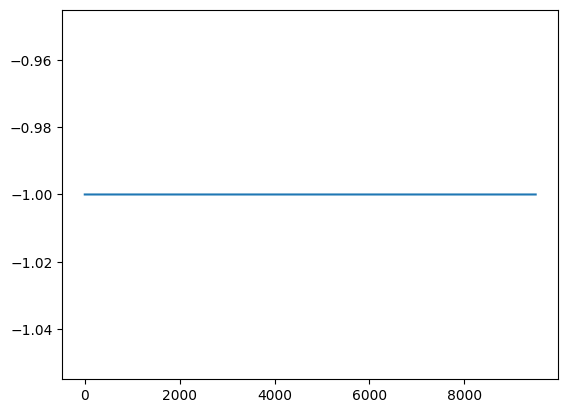

In [4]:
tt_path = path+'headstage_0/tt.pkl'
with open(tt_path, 'rb') as file:
    tt = pickle.load(file)
plt.plot(tt['condition'])

In [5]:
analog_channels = np.load(path + "/analog_in.npy")

In [6]:
triggers = analog_channels[0] 


In [7]:
x_bin = np.where(triggers ** 2 <= 1, 0, 1)

In [8]:
#peaks = find_peaks(x_bin, height=0.5, plateau_size=[5, 10])
peaks = find_peaks(x_bin, height=1, distance=int(0.005 * 30000), plateau_size=[5, 10])

In [9]:
len(peaks[1]["left_edges"])

62

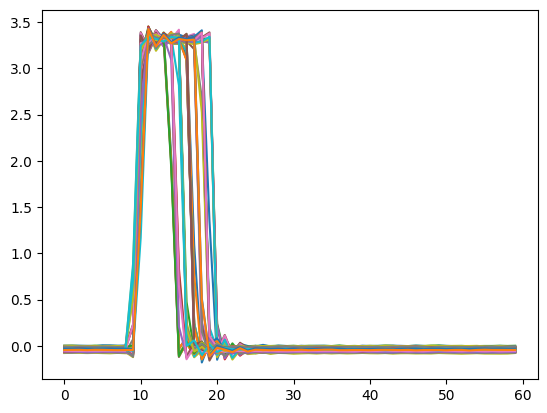

In [10]:
for peak in peaks[1]["left_edges"]:
    plt.plot(triggers[peak-10:peak + 50])
plt.show()

TR : 0
TR : 0
TR : 0


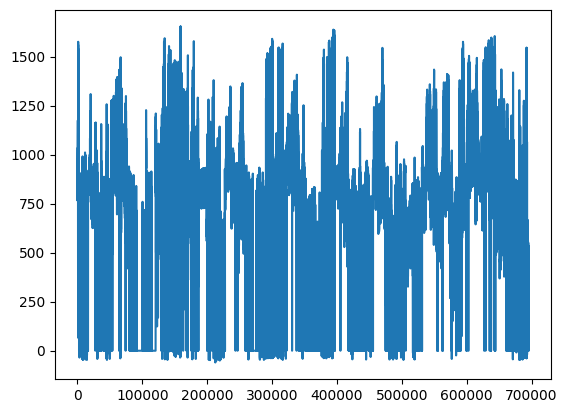

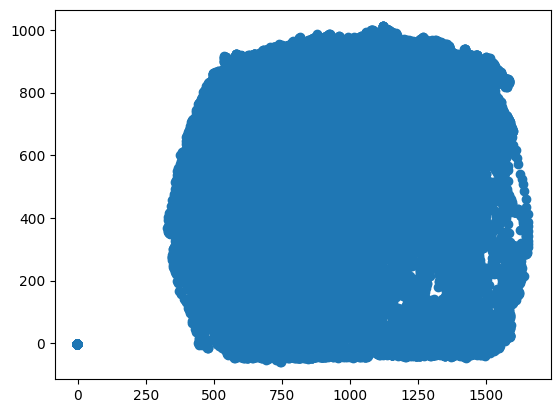

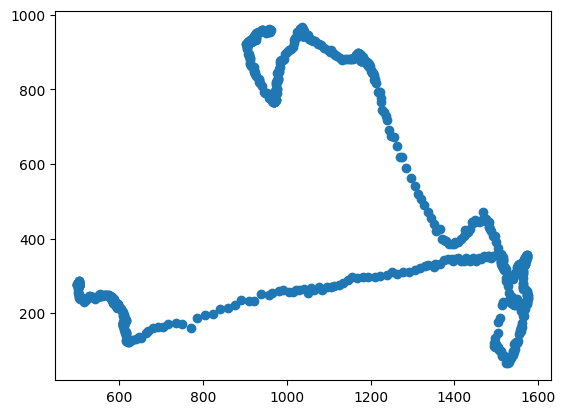

IndexError: list index out of range

In [11]:
positions = rs.load_positions_file(path)
print(positions)
p = positions["TR"][0]
# Attention, positions en deux dimensions !
p = np.fromfile(p, dtype=np.int32)
x_p = p[np.arange(0, len(p), step=2)]
y_p = p[np.arange(1, len(p), step=2)]
mapping = rs.Mapping(1920, 33, 2000., 7)
clean_positions(x_p)  # Pour retirer les -1.
tones_from_positions = rs.detect_frequency_switch(positions, mapping, None)

# Espérer que tones_from_positions == tones.
# Si c'est bon, regarder la sortie digitale n°0 possiblement.

In [39]:
print(len(tt['tones']))
print(len(tt['triggers']))

9504
9426


In [14]:
d_tones = np.diff(tt["tones"])
u, c = np.unique(d_tones, return_counts=True)
sum(np.equal(u, 0))

0

In [17]:
data = np.load(path+'headstage_0/data_0.005.npy', allow_pickle=True)
features = np.load(path+'headstage_0/features_0.005.npy', allow_pickle=True)
gc = np.load(path+'headstage_0/good_clusters.npy', allow_pickle=True)

In [7]:
#je retire les 5 premières minutes 
#data = np.array(data)[:, 60000:]
#features = np.array(features)[60000:]

In [18]:
print(len(data[0]))
print(len(features))

527488
527488


In [19]:
tracking = get_psth(data, features, t_pre, t_post, bin_width, gc, 'tail')
#playback = get_psth(data, features, t_pre, t_post, bin_width, gc, 'playback')
#tracking = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, 1, 'tracking')

In [20]:
n = int(len(tracking[0])/4)
tracking = np.array(tracking)
first_tr = tracking[:,:n]
second_tr = tracking[:,n:2*n]
third_tr = tracking[:,2*n:3*n]
fourth_tr = tracking[:,3*n:]

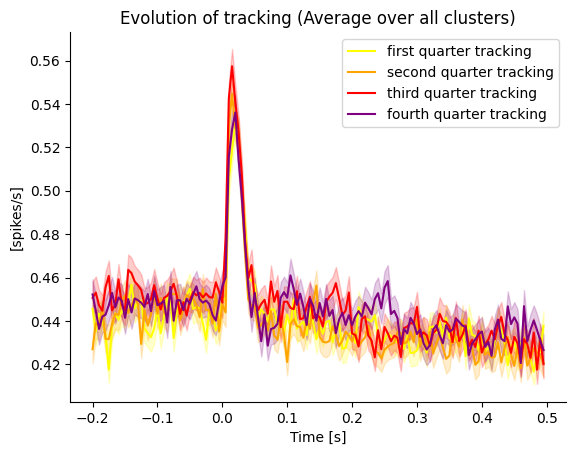

In [21]:
# la moyenne sur tous les clusters
c_tracking = np.nanmean(first_tr, axis=0)
cc_tracking = np.nanmean(second_tr, axis=0)
ccc_tracking = np.nanmean(third_tr, axis=0)
cccc_tracking = np.nanmean(fourth_tr, axis=0)

m_tracking = np.nanmean(c_tracking, axis=0)
mm_tracking = np.nanmean(cc_tracking, axis=0)
mmm_tracking = np.nanmean(ccc_tracking, axis=0)
mmmm_tracking = np.nanmean(cccc_tracking, axis=0)

sem_tr = get_sem(c_tracking)
sem_pb = get_sem(cc_tracking)
sem_ccc = get_sem(ccc_tracking)
sem_cccc = get_sem(cccc_tracking)


plt.plot(psth_bins, m_tracking, c = 'yellow', label = 'first quarter tracking')
plt.plot(psth_bins, mm_tracking, c = 'orange',  label = 'second quarter tracking')
plt.plot(psth_bins, mmm_tracking, c = 'red',  label = 'third quarter tracking')
plt.plot(psth_bins, mmmm_tracking, c = 'purple',  label = 'fourth quarter tracking')

plt.fill_between(psth_bins, m_tracking - sem_tr, m_tracking + sem_tr, color='yellow', alpha=0.2)
plt.fill_between(psth_bins, mm_tracking - sem_pb, mm_tracking + sem_pb, color='orange', alpha=0.2)
plt.fill_between(psth_bins, mmm_tracking - sem_ccc, mmm_tracking + sem_ccc, color='red', alpha=0.2)
plt.fill_between(psth_bins, mmmm_tracking - sem_cccc, mmmm_tracking + sem_cccc, color='purple', alpha=0.2)
plt.title('Evolution of tracking (Average over all clusters)')
plt.xlabel('Time [s]')
#plt.ylim(0.31, .65)
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

32


IndexError: index 12 is out of bounds for axis 0 with size 12

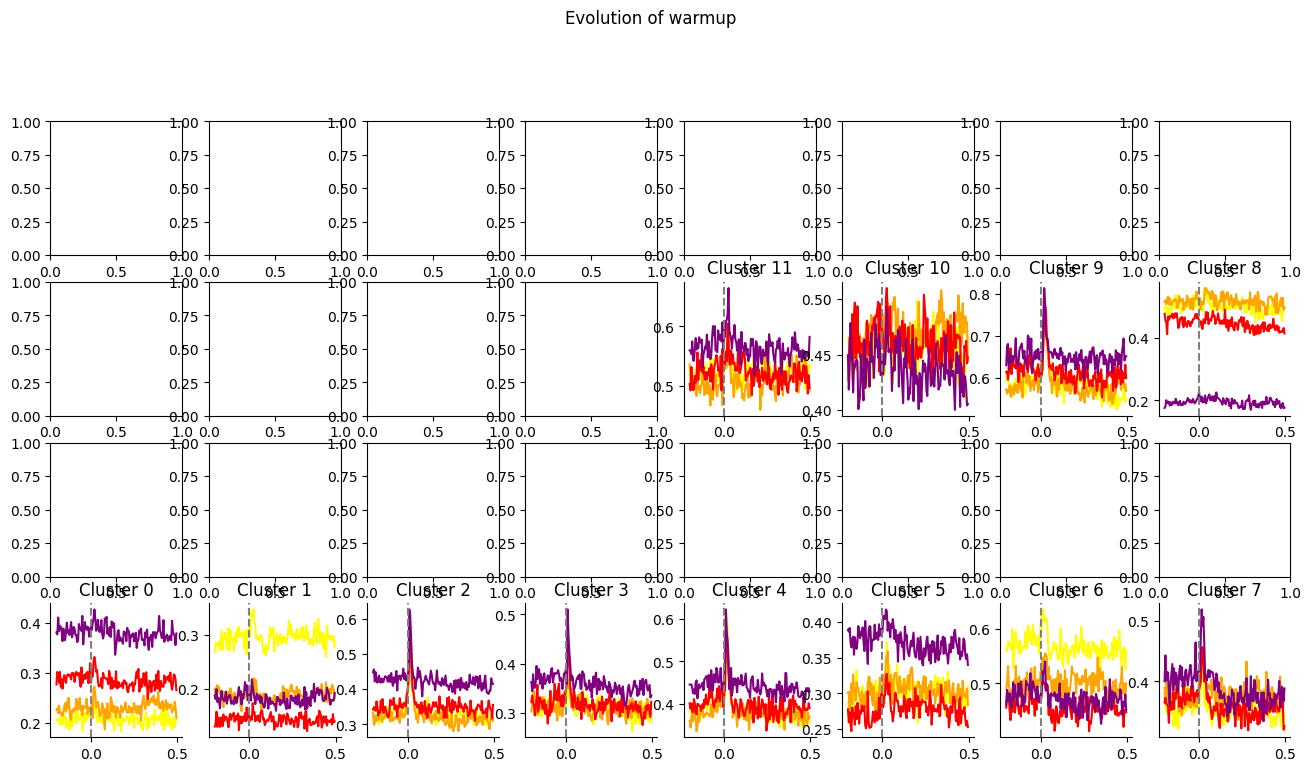

In [12]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Evolution of warmup', y=1.02)
plt.subplots_adjust() 
num_plots, num_rows, num_columns = get_better_plot_geometry(np.arange(32))
print(num_plots)
psth_bins = np.arange(-t_pre, t_post, bin_width)
for cluster in np.arange(32):
    if cluster <num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, np.nanmean(first_tr[cluster], axis=0), c = 'yellow')
        axes[row, col].plot(psth_bins, np.nanmean(second_tr[cluster], axis=0), c = 'orange')
        axes[row, col].plot(psth_bins, np.nanmean(third_tr[cluster], axis=0), c = 'red')
        axes[row, col].plot(psth_bins, np.nanmean(fourth_tr[cluster], axis=0), c = 'purple')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
#plt.savefig(path+'headstage_0/psth_cluster.png')


In [ ]:
# la moyenne sur tous les clusters
c_tracking = np.nanmean(first_tr, axis=0)
cc_tracking = np.nanmean(second_tr, axis=0)
ccc_tracking = np.nanmean(third_tr, axis=0)
cccc_tracking = np.nanmean(fourth_tr, axis=0)

m_tracking = np.nanmean(c_tracking, axis=0)
mm_tracking = np.nanmean(cc_tracking, axis=0)
mmm_tracking = np.nanmean(ccc_tracking, axis=0)
mmmm_tracking = np.nanmean(cccc_tracking, axis=0)

sem_tr = get_sem(c_tracking)
sem_pb = get_sem(cc_tracking)
sem_ccc = get_sem(ccc_tracking)
sem_cccc = get_sem(cccc_tracking)


plt.plot(psth_bins, m_tracking, c = 'yellow', label = 'first quarter tracking')
plt.plot(psth_bins, mm_tracking, c = 'orange',  label = 'second quarter tracking')
plt.plot(psth_bins, mmm_tracking, c = 'red',  label = 'third quarter tracking')
plt.plot(psth_bins, mmmm_tracking, c = 'purple',  label = 'fourth quarter tracking')

plt.fill_between(psth_bins, m_tracking - sem_tr, m_tracking + sem_tr, color='yellow', alpha=0.2)
plt.fill_between(psth_bins, mm_tracking - sem_pb, mm_tracking + sem_pb, color='orange', alpha=0.2)
plt.fill_between(psth_bins, mmm_tracking - sem_ccc, mmm_tracking + sem_ccc, color='red', alpha=0.2)
plt.fill_between(psth_bins, mmmm_tracking - sem_cccc, mmmm_tracking + sem_cccc, color='purple', alpha=0.2)
plt.title('Evolution of tracking (Average over all clusters)')
plt.xlabel('Time [s]')
#plt.ylim(0.31, .65)
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()